# Grad-CAM Visualization for Swin-Transformer

This notebook demonstrates how to compute a Grad-CAM heatmap for a SwinTransformerClassifier. We will:

1. Load necessary libraries and modules.
2. Define hook functions for capturing activations and gradients.
3. Preprocess an input image (resize, normalize) to feed into the model.
4. Compute the Grad-CAM heatmap by backpropagating the target class score.
5. Overlay the heatmap on the original image and display the result.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
import cv2  # used for applying the colormap

# Import the classifier
from models.swin_transformer_classifier import SwinTransformerClassifier

# Global containers to store the activation and its gradient
activations = None
gradients = None

/opt/conda/envs/realmmlab/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Define Hook Functions

These hook functions are used to capture intermediate activations and gradients from the target layer (which is chosen as the patch-embedding projection layer in the Swin Transformer). The forward hook stores the activations, and the backward hook stores the gradients.

In [7]:
def forward_hook(module, input, output):
    global activations
    if isinstance(output, tuple):
        activations = output[0]  # Extract the first element if output is a tuple
    else:
        activations = output

def backward_hook(module, grad_input, grad_output):
    global gradients
    if isinstance(grad_output, tuple):
        gradients = grad_output[0]  # Extract the first element if grad_output is a tuple
    else:
        gradients = grad_output

## Preprocess Image and Generate Heatmap Overlay

The following function loads and preprocesses an image. It resizes the image to the target size, converts it into a tensor, and normalizes it with the same ImageNet means and standard deviations. We also keep a copy of the original image (as a PIL image) for the purpose of overlaying the generated heatmap.

In [3]:
def preprocess_image(image_path, target_size=(384, 384)):
    """
    Load and preprocess an image.
    The processing steps include:
      - Resize the image to the target size
      - Convert the image to a tensor
      - Normalize with ImageNet mean and std
    """
    transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0), image  # return tensor and original PIL image

Next, we define a function to generate a heatmap overlay on the original image. This function applies a color map to the Grad-CAM output and then overlays it on the input image.

In [29]:
def generate_heatmap_on_image(original_img, cam, alpha=0.5):
    """
    Overlay the heatmap on the original image.
    Args:
        original_img: PIL Image
        cam: numpy array (H, W), normalized between 0 and 1.
        alpha: Transparency of the heatmap.
    Returns:
        overlay: Heatmap overlaid on the original image (numpy array).
        heatmap: Heatmap only (numpy array).
    """
    img = np.array(original_img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cam = cv2.resize(cam, (img.shape[1], img.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(heatmap, alpha, img, 1 - alpha, 0)
    overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    return overlay, heatmap

def visualize_heatmap(image_path, cam, predicted_class_name, alpha=0.5, save_path=None):
    """
    Visualize the original image, overlay, heatmap, and colorbar in a single figure.
    Args:
        image_path: Path to the image file.
        cam: numpy array (H, W), normalized between 0 and 1.
        predicted_class_name: Predicted class name.
        alpha: Transparency of the heatmap.
        save_path: Optional path to save the visualization.
    """
    original_img = Image.open(image_path)
    overlay, heatmap = generate_heatmap_on_image(original_img, cam, alpha)

    # Extract the image name from the image_path
    image_name = image_path.split("/")[-1]
    
    # Create a figure with four subplots
    fig = plt.figure(figsize=(16, 6))
    gs = fig.add_gridspec(1, 4, width_ratios=[1, 1, 1, 0.05])  # Make colorbar narrower
    
    # Set the figure title (predicted class name)
    fig.suptitle(f"Predicted Class: {predicted_class_name}", fontsize=14, y=1.0)
    
    # Plot the original image
    ax1 = fig.add_subplot(gs[0])
    ax1.imshow(original_img)
    ax1.axis('off')
    ax1.set_title(f"Original Image\n{image_name}")
    
    # Plot the overlay
    ax2 = fig.add_subplot(gs[1])
    ax2.imshow(overlay)
    ax2.axis('off')
    ax2.set_title("Overlay (Heatmap + Original)")
    
    # Plot the heatmap
    ax3 = fig.add_subplot(gs[2])
    ax3.imshow(heatmap)
    ax3.axis('off')
    ax3.set_title("Heatmap Only")
    
    # Plot the colorbar
    ax4 = fig.add_subplot(gs[3])
    im = ax4.imshow(cam, cmap='jet', aspect='auto', vmin=0, vmax=1)
    
    # Add a smaller colorbar
    cbar = plt.colorbar(im, cax=ax4, orientation='vertical', shrink=0.6)  # Shrink the colorbar
    ax4.axis('off')
    
    # Add text below the colorbar
    fig.text(0.88, 0.1, "Heatmap Intensity\n(Blue = Low, Red = High)", 
             ha='center', va='center', fontsize=10, color='black')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0.1)
    
    plt.show()

## Compute Grad-CAM

In the function below we perform the following steps:

1. Register forward and backward hooks to capture activations and gradients from the target layer. Here, we assume that the target layer is the patch-embedding projection layer (`model.swin_model.swin_model.patch_embed.proj`).
2. Run a forward pass on the input image.
3. Determine the target class (if not provided, the highest logit is chosen).
4. Run a backward pass to compute gradients with respect to the target class score.
5. Compute the Grad-CAM by pooling the gradients across the spatial dimensions and performing a weighted sum of the activations.
6. Normalize the resulting heatmap between 0 and 1.

In [30]:
def compute_gradcam(model, input_tensor, target_size=None, target_class=None):
    global activations, gradients
    activations = None
    gradients = None

    # Register hooks on the patch embeddings layer
    target_layer = model.swin_model.swin.embeddings.patch_embeddings

    hook_handle_forward = target_layer.register_forward_hook(forward_hook)
    hook_handle_backward = target_layer.register_full_backward_hook(backward_hook)

    model.zero_grad()  # Clear gradients before forward pass
    input_tensor.requires_grad_(True)  # Ensure input tensor requires gradients

    output = model(input_tensor)  # Forward pass
    
    if target_class is None:
        target_class = output.argmax(dim=-1).item()

    score = output[0, target_class]

    score.backward()  # Backward pass

    hook_handle_forward.remove()
    hook_handle_backward.remove()

    # Debugging: Check if gradients are captured
    if gradients is None:
        raise ValueError("Gradients were not captured. Check the backward hook and target layer.")

    # Reshape activations and gradients to [batch_size, channels, height, width]
    if target_size is None:    
        H, W = 384, 384  # Input image size
    else:
        (H, W) = target_size
    P = 4  # Patch size
    activations = activations.reshape(1, H // P, W // P, -1).permute(0, 3, 1, 2)
    gradients = gradients.reshape(1, H // P, W // P, -1).permute(0, 3, 1, 2)

    # Compute Grad-CAM
    pooled_gradients = torch.mean(gradients, dim=[2, 3], keepdim=True)
    weighted_activation = pooled_gradients * activations
    cam = torch.sum(weighted_activation, dim=1).squeeze()
    cam = torch.relu(cam)

    cam_np = cam.detach().cpu().numpy()
    if np.max(cam_np) != 0:
        cam_np = cam_np / np.max(cam_np)
    else:
        cam_np = np.zeros_like(cam_np)

    return cam_np, target_class

## Main Function

The main function puts everything together:

1. It sets configuration values like the image path, number of classes, and model weights path.
2. It loads the pre-trained model using `SwinTransformerClassifier.load_model`.
3. It pre-processes the input image and sends it to the proper device.
4. It computes the Grad-CAM, prints the predicted class, and generates the heatmap overlay.
5. Finally, it displays the result.

Predicted class:  Healthy


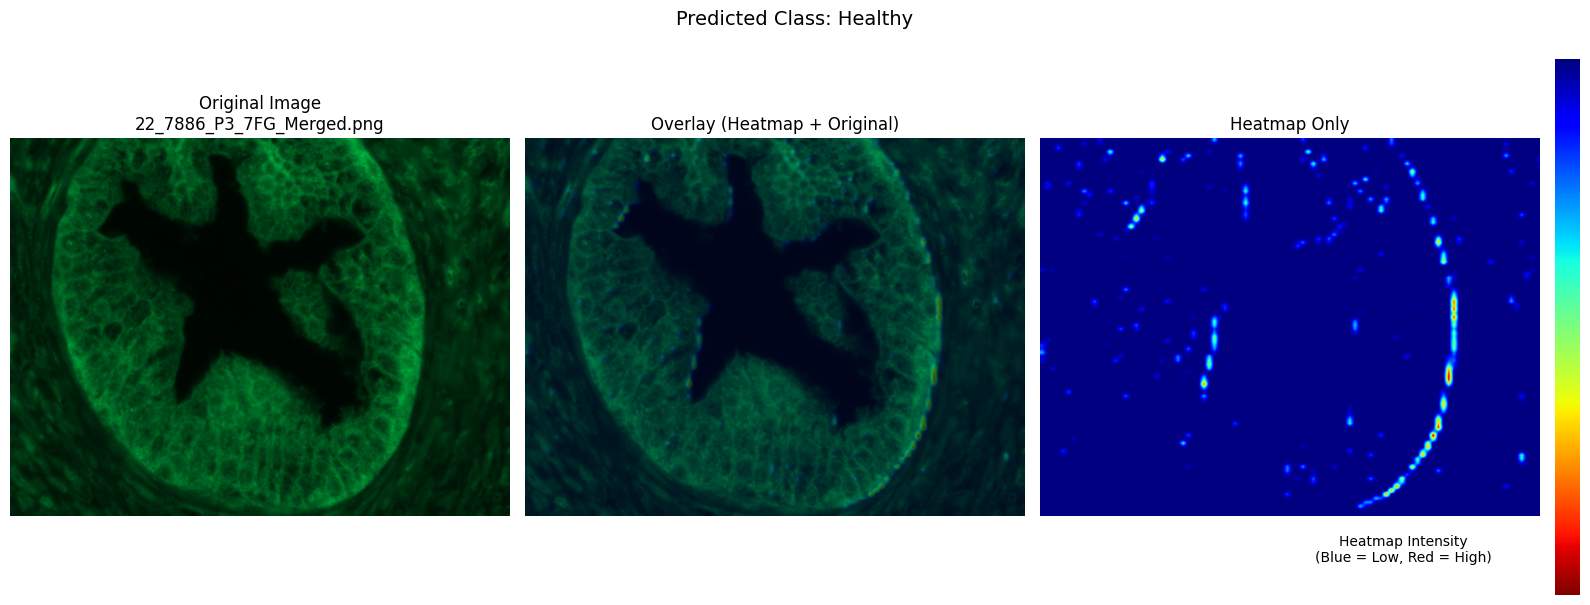

In [40]:
def main():
    # ----------------------------
    # Configuration / arguments
    # ----------------------------
    # Path to an image file (change to your image file path)
    image_path = "split/classification/Merged/test/Healthy/22_7886_P3_7FG_Merged.png"
    
    # Set the number of classes in your model
    num_classes = 3
    target_size = (384, 384)
    
    # Class names
    class_names = ["Gl6", "Gl9", "Healthy"]
    
    # Path to your model weights
    model_weight_path = "Model_F_swintransformerclassifier_final_20250221_153017.pth"
    
    # Load the model using the provided weights
    model = SwinTransformerClassifier.load_model(
                model_weight_path=model_weight_path,
                num_classes=num_classes,
                train_path=None,
                val_path=None,
                test_path=None,
                optimizer="adam",
                lr=1e-3,
                batch_size=16,
                transfer=True,
                tune_fc_only=True,
                target_size=target_size
            )
    model.eval()

    # Put model on device (CPU or GPU)
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    device = torch.device("cpu")
    model.to(device)

    # -------------------------------
    # Preprocess the image
    # -------------------------------
    input_tensor, original_img = preprocess_image(image_path, target_size=target_size)
    input_tensor = input_tensor.to(device)

    # ----------------------------------
    # Compute Grad-CAM
    # ----------------------------------
    cam_np, predicted_class = compute_gradcam(model, input_tensor, target_size)
    class_name = class_names[predicted_class]
    print("Predicted class: ", class_name)

    # ----------------------------------
    # Visualize and save the result
    # ----------------------------------
    visualize_heatmap(image_path, cam_np, class_name, alpha=0.2, save_path="gradcam_overlay.png")

main()

## Summary

This notebook showed how to:

- Use forward and backward hooks in PyTorch to capture intermediate activations and gradients.
- Preprocess an input image using standard transforms.
- Compute a Grad-CAM heatmap highlighting the regions in the image that contributed most to the prediction.
- Overlay the heatmap on the original image and visualize the final result.

Make sure to update the file paths (`image_path` and `model_weight_path`) to point to your own image and model weight files before running the notebook.